# Marceli Korbin and Mikołaj Malec  - Project A

In [3]:
# Insatll if necessery
#!pip install --no-deps pyitlib

import pandas as pd
import numpy as np
from tabulate import tabulate

import time

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris, load_wine
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectFromModel, RFE, SelectKBest, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from sklearn.metrics import accuracy_score, mutual_info_score
from pyitlib.discrete_random_variable import information_mutual, information_mutual_conditional

# Set seed for reproducibility
np.random.seed(42)

In [4]:
# MiniMax
# Function to calculate conditional mutual information
def conditional_mutual_information(X, Y, Z):
    z_values = np.unique(Z)
    n = len(Z)
    cmi = 0

    for z_value_tmp in z_values:
        z_condition = (Z == z_value_tmp)
        X_z = X[z_condition]
        Y_z = Y[z_condition]
        mi_XY_z = mutual_info_score(X_z, Y_z)
        p_z = np.sum(z_condition)/n
        cmi += p_z*mi_XY_z

    return cmi

# Define the mini-max feature selection method
def mini_max_feature_selection(X, y, num_features):
    N, K = X.shape
    selected_features = []
    remaining_features = list(range(K))

    # Step 0: Discretize using Sturges' Rule (log_2(N))
    discretizer = KBinsDiscretizer(n_bins=int(np.round(np.log2(N))),
                                   encode='ordinal', strategy='uniform')
    X = discretizer.fit_transform(X)

    # Step 1: Compute initial mutual information for all features
    """
    mutual_info = np.zeros(K)
    for i in range(K):
        mutual_info[i] = information_mutual(X[:,i], y)
    """
    mutual_info = mutual_info_classif(X, y)

    # Step 2: Select features iteratively
    for _ in range(num_features):
        # Step 2.1: Select the feature with the maximum score
        nu_k = np.argmax(mutual_info)
        mutual_info[nu_k] = 0 # Drop the mutual information value of the selected index
        selected_features.append(nu_k)
        remaining_features = [f for f in remaining_features if f not in selected_features]  # Remove selected feature

        # Step 2.2: Update scores of remaining features
        for n in remaining_features:
            # Compute conditional mutual information for remaining features
            # mutual_info_Y_X_n_cond_X_k = information_mutual_conditional( y, X[:,n], X[:,nu_k])
            mutual_info_Y_X_n_cond_X_k = conditional_mutual_information(y, X[:,n], X[:,nu_k])
            mutual_info[n] = min(mutual_info[n], mutual_info_Y_X_n_cond_X_k)
    return selected_features

# Define the custom transformer class for mini-max feature selection
class MiniMaxFeatureSelection(BaseEstimator, TransformerMixin):
    def __init__(self, num_features):
        self.num_features = num_features

    def fit(self, X, y):
        self.selected_features_ = mini_max_feature_selection(X, y, self.num_features)
        return self

    def transform(self, X):
        return X[:, self.selected_features_]


In [5]:
# JMI
# Function to calculate joint mutual information
def calculate_jmi(X, y, features):
    jmi_score = 0
    for feature_idx in features:
        jmi_score += mutual_info_classif(X[:, feature_idx].reshape(-1, 1), y)[0]
    return jmi_score

# Function to select features using JMI
def jmi_feature_selection(X, y, num_features):
    # Calculate mutual information scores for each feature
    mi_scores = mutual_info_classif(X, y)

    # Sort features based on their mutual information scores
    sorted_indices = np.argsort(mi_scores)[::-1]

    # Select top k features using JMI
    selected_features = [sorted_indices[0]]  # Initialize with the most informative feature
    for i in range(1, num_features):
        best_feature = None
        best_jmi = -np.inf
        for feature_idx in sorted_indices:
            if feature_idx not in selected_features:
                jmi_score = calculate_jmi(X, y, selected_features + [feature_idx])
                if jmi_score > best_jmi:
                    best_feature = feature_idx
                    best_jmi = jmi_score
        selected_features.append(best_feature)

    return selected_features

# Define the custom transformer class for JMI feature selection
class JMIFeatureSelection(BaseEstimator, TransformerMixin):
    def __init__(self, num_features):
        self.num_features = num_features

    def fit(self, X, y):
        self.selected_features_ = jmi_feature_selection(X, y, self.num_features)
        return self

    def transform(self, X):
        return X[:, self.selected_features_]


In [6]:
# SECMI
# Function to select features using SECMI
def secmi_feature_selection(X, y, num_features):
    N, n_features = X.shape
    remaining_features = list(range(n_features))

    # Discretize using Sturges' Rule (log_2(N))
    discretizer = KBinsDiscretizer(n_bins=int(np.round(np.log2(N))),
                                   encode='ordinal', strategy='uniform')
    X = discretizer.fit_transform(X)

    # Calculate mutual information scores for each feature
    mi_scores = mutual_info_classif(X, y, discrete_features=True)

    # Sort features based on their mutual information scores
    first_feature = np.argmax(mi_scores)
    selected_features = [first_feature]  # Initialize with the most informative feature
    remaining_features.remove(first_feature)

    # Select top k features using SECMI
    for i in range(1, num_features):
        best_feature = None
        best_secmi = -np.inf
        for feature_idx in remaining_features:
            secmi_value = mi_scores[feature_idx]
            for selected_feature in selected_features:
                redundancy = conditional_mutual_information(X[:, feature_idx], y, X[:, selected_feature])
                secmi_value -= redundancy
            if secmi_value > best_secmi:
                best_feature = feature_idx
                best_secmi = secmi_value
        selected_features.append(best_feature)
        remaining_features.remove(best_feature)

    return selected_features

# Define the custom transformer class for SECMI feature selection
class SECMIFeatureSelection(BaseEstimator, TransformerMixin):
    def __init__(self, num_features):
        self.num_features = num_features

    def fit(self, X, y):
        self.selected_features_ = secmi_feature_selection(X, y, self.num_features)
        return self

    def transform(self, X):
        return X[:, self.selected_features_]

In [7]:
def main_pipeline(X, y, n_iterations = 10, print_debug=False):
    # Create list of number of features to test
    p = X.shape[1]
    k_grid  = [int(max(np.round(percent * p),1)) for percent in [0.1, 0.3, 0.5, 0.7]]

    # Define a DataFrame to store results
    results = pd.DataFrame(columns=['Method', 'Selected Features', 'Test Accuracy', 'Execution Time'])

    for i in range(n_iterations):
        # Test-Train Split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

        t_start = time.time()
        # Method 0: All Features
        # Fit Decision Tree Classifier
        all_classifier = DecisionTreeClassifier()
        all_classifier.fit(X_train, y_train)

        # Evaluate on the test set
        y_pred_all = all_classifier.predict(X_test)
        accuracy_all = accuracy_score(y_test, y_pred_all)
        t0 = time.time()
        results = pd.concat([results, pd.DataFrame({'Method': ['All Features'],
                                                    'Selected Features': [X_train.shape[1]],
                                                    'Test Accuracy': [accuracy_all],
                                                    'Execution Time': [t0-t_start]})], ignore_index=True)
        if print_debug:
          print("Method 1")
        # Method 1: Lasso Regularization for Feature Selection
        lasso_pipeline = Pipeline([
            ('scaler', StandardScaler()),  # Standardize features
            ('lasso', Lasso())             # Lasso regression
        ])

        # Define the parameter grid for alpha values
        param_grid_alpha = {'lasso__alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]}

        # Perform grid search with cross-validation
        lasso_grid_search = GridSearchCV(lasso_pipeline, param_grid_alpha, cv=5)
        lasso_grid_search.fit(X_train, y_train)

        # Get the best alpha value
        best_alpha = lasso_grid_search.best_params_['lasso__alpha']

        # Use the best alpha to fit Lasso and select features
        lasso = Lasso(alpha=best_alpha)
        lasso.fit(X_train, y_train)
        selected_features_lasso = SelectFromModel(lasso, prefit=True).transform(X_train)
        X_test_selected_lasso = SelectFromModel(lasso, prefit=True).transform(X_test)

        # Fit Decision Tree Classifier
        la_classifier = DecisionTreeClassifier()
        la_classifier.fit(selected_features_lasso, y_train)

        # Evaluate on the test set
        y_pred_lasso = la_classifier.predict(X_test_selected_lasso)
        accuracy_lasso = accuracy_score(y_test, y_pred_lasso)
        t1 = time.time()
        results = pd.concat([results, pd.DataFrame({'Method': ['Lasso Regularization'],
                                                    'Selected Features': [selected_features_lasso.shape[1]],
                                                    'Test Accuracy': [accuracy_lasso],
                                                    'Execution Time': [t1-t0]})], ignore_index=True)

        if print_debug:
          print("Method 2")
        # Method 2: Decision Tree-based Feature Importance
        param_grid_threshold = {'feature_selection__threshold': [0.01, 0.02, 0.03, 0.04, 0.05]}

        dt_pipeline = Pipeline([
            ('feature_selection', SelectFromModel(DecisionTreeClassifier())),
            ('classification', DecisionTreeClassifier())
        ])

        dt_grid_search = GridSearchCV(dt_pipeline, param_grid_threshold, cv=5)
        dt_grid_search.fit(X_train, y_train)

        best_model = dt_grid_search.best_estimator_

        selector = best_model.named_steps['feature_selection']
        selected_features_dt = selector.transform(X_train)
        X_test_selected_dt = selector.transform(X_test)

        dt_final_model = DecisionTreeClassifier()
        dt_final_model.fit(selected_features_dt, y_train)

        y_pred_dt = dt_final_model.predict(X_test_selected_dt)
        accuracy_dt = accuracy_score(y_test, y_pred_dt)
        t2 = time.time()
        results = pd.concat([results, pd.DataFrame({'Method': ['Decision Tree-based Feature Importance'],
                                                    'Selected Features': [selected_features_dt.shape[1]],
                                                    'Test Accuracy': [accuracy_dt],
                                                    'Execution Time': [t2-t1]})], ignore_index=True)

        if print_debug:
          print("Method 3")
        # Method 3: Recursive Feature Elimination (RFE)
        param_grid_k_rfe = {'n_features_to_select': k_grid}

        rfe_grid_search = GridSearchCV(RFE(estimator=DecisionTreeClassifier()), param_grid_k_rfe, cv=5)
        rfe_grid_search.fit(X_train, y_train)

        best_n_features = rfe_grid_search.best_params_['n_features_to_select']

        rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=best_n_features)

        rfe.fit(X_train, y_train)

        selected_features_rfe = X_train[:, rfe.support_]
        X_test_selected_rfe = X_test[:, rfe.support_]

        rfe_final_model = DecisionTreeClassifier()
        rfe_final_model.fit(selected_features_rfe, y_train)

        y_pred_rfe = rfe_final_model.predict(X_test_selected_rfe)
        accuracy_rfe = accuracy_score(y_test, y_pred_rfe)
        t3 = time.time()
        results = pd.concat([results, pd.DataFrame({'Method': ['Recursive Feature Elimination'],
                                                    'Selected Features': [rfe.n_features_],
                                                    'Test Accuracy': [accuracy_rfe],
                                                    'Execution Time': [t3-t2]})], ignore_index=True)

        if print_debug:
          print("Method 4")
        # Method 4: Min-Max Feature Selection
        param_grid_k_min_max = {'feature_selection__num_features': k_grid}

        # Define the pipeline with feature selection and classifier
        min_max_pipeline = Pipeline([
            ('feature_selection', MiniMaxFeatureSelection(num_features=4)),
            ('classification', DecisionTreeClassifier())
        ])

        # Perform grid search with cross-validation
        min_max_grid_search = GridSearchCV(min_max_pipeline, param_grid_k_min_max, cv=5)
        min_max_grid_search.fit(X_train, y_train)

        # Get the best number of features selected
        best_num_features_min_max = min_max_grid_search.best_params_['feature_selection__num_features']

        # Select features using the best number of features
        selected_min_max_indx = mini_max_feature_selection( X_train, y_train,
                                                             num_features=best_num_features_min_max)

        selected_features_min_max = X_train[:, selected_min_max_indx]
        X_test_selected_min_max = X_test[:, selected_min_max_indx]

        min_max_final_model = DecisionTreeClassifier()
        min_max_final_model.fit(selected_features_min_max, y_train)

        y_pred_min_max = min_max_final_model.predict(X_test_selected_min_max)
        accuracy_min_max = accuracy_score(y_test, y_pred_min_max)
        t4 = time.time()
        results = pd.concat([results, pd.DataFrame({'Method': ['Min-Max Feature Selection'],
                                                    'Selected Features': [selected_features_min_max.shape[1]],
                                                    'Test Accuracy': [accuracy_min_max],
                                                    'Execution Time': [t4-t3]})], ignore_index=True)

        if print_debug:
          print("Method 5")
        # Method 5: JMI Feature Selection
        param_grid_k_jmi = {'feature_selection__num_features': k_grid}

        # Define the pipeline with feature selection and classifier
        jmi_pipeline = Pipeline([
            ('feature_selection', JMIFeatureSelection(num_features=4)),
            ('classification', DecisionTreeClassifier())
        ])

        # Perform grid search with cross-validation
        jmi_grid_search = GridSearchCV(jmi_pipeline, param_grid_k_jmi, cv=5)
        jmi_grid_search.fit(X_train, y_train)

        # Get the best number of features selected
        best_num_features_jmi = jmi_grid_search.best_params_['feature_selection__num_features']

        # Select features using the best number of features
        selected_jmi_indx = jmi_feature_selection(X_train, y_train,
                                                  num_features=best_num_features_jmi)

        selected_features_jmi = X_train[:, selected_jmi_indx]
        X_test_selected_jmi = X_test[:, selected_jmi_indx]

        jmi_final_model = DecisionTreeClassifier()
        jmi_final_model.fit(selected_features_jmi, y_train)

        y_pred_jmi = jmi_final_model.predict(X_test_selected_jmi)
        accuracy_jmi = accuracy_score(y_test, y_pred_jmi)
        t5 = time.time()
        results = pd.concat([results, pd.DataFrame({'Method': ['JMI Feature Selection'],
                                                    'Selected Features': [selected_features_jmi.shape[1]],
                                                    'Test Accuracy': [accuracy_jmi],
                                                    'Execution Time': [t5-t4]})], ignore_index=True)

        if print_debug:
          print("Method 6")
        # Method 6: SECMI Feature Selection
        param_grid_k_secmi = {'feature_selection__num_features': k_grid}

        # Define the pipeline with feature selection and classifier
        secmi_pipeline = Pipeline([
            ('feature_selection', SECMIFeatureSelection(num_features=4)),
            ('classification', DecisionTreeClassifier())
        ])

        # Perform grid search with cross-validation
        secmi_grid_search = GridSearchCV(secmi_pipeline, param_grid_k_secmi, cv=5)
        secmi_grid_search.fit(X_train, y_train)

        # Get the best number of features selected
        best_num_features_secmi = secmi_grid_search.best_params_['feature_selection__num_features']

        # Select features using the best number of features
        selected_secmi_indx = secmi_feature_selection(X_train, y_train,
                                                  num_features=best_num_features_secmi)

        selected_features_secmi = X_train[:, selected_secmi_indx]
        X_test_selected_secmi = X_test[:, selected_secmi_indx]

        secmi_final_model = DecisionTreeClassifier()
        secmi_final_model.fit(selected_features_secmi, y_train)

        y_pred_secmi = secmi_final_model.predict(X_test_selected_secmi)
        accuracy_secmi = accuracy_score(y_test, y_pred_secmi)
        t6 = time.time()
        results = pd.concat([results, pd.DataFrame({'Method': ['SECMI Feature Selection'],
                                                    'Selected Features': [selected_features_secmi.shape[1]],
                                                    'Test Accuracy': [accuracy_secmi],
                                                    'Execution Time': [t6-t5]})], ignore_index=True)
    return results

def aggregate_results(results):
    # Calculate averages and variances
    method_avg_selected = results.groupby('Method')['Selected Features'].mean()
    method_avg_accuracy = results.groupby('Method')['Test Accuracy'].mean()
    method_var_accuracy = results.groupby('Method')['Test Accuracy'].var()
    method_avg_time = results.groupby('Method')['Execution Time'].mean()

    # Combine results into a new DataFrame
    grouped_results = pd.DataFrame({
        'Avg Selected Features': method_avg_selected,
        'Avg Test Accuracy': method_avg_accuracy,
        'Var Test Accuracy': method_var_accuracy,
        'Avg Execution Time': np.round(method_avg_time,3),
    }).reset_index()

    return grouped_results

# Creating the box plot
def plot_boxplot(results, name):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="Method", y="Test Accuracy", data=results)
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Box Plot of Test Accuracy by Method of the {name} Datset")
    plt.tight_layout()
    plt.show()

In [8]:
# Artificial datasets
n = 500
def discretize_2bins(X):
    X_discrete = 2*(X >= 0)-1
    return X_discrete

# Example 1 (expected to work)
y_artificial1 = discretize_2bins(np.random.normal(size=n))
y_add = np.repeat(y_artificial1.reshape((-1, 1)), 3, axis=1)
X_artificial1_A = discretize_2bins(np.random.multivariate_normal([1, 1, 1], np.eye(3), size=n) + y_add)
X_artificial1_B = discretize_2bins(np.random.normal(size=n) + X_artificial1_A[:, 0])
X_artificial1 = np.concatenate((X_artificial1_A, X_artificial1_B.reshape(-1, 1)), axis=1)

# Example 2 (not expected to work)
X_artificial2 = np.random.binomial(1, 0.5, (n, 4))
X_add = np.sum(X_artificial2, axis=1)
condition_zero = (X_add % 2 == 0)
y_artificial2 = np.random.binomial(1, 0.8, n)
y_artificial2[condition_zero] = 1 - y_artificial2[condition_zero]

In [9]:
# Real-life datasets
from sklearn.datasets import load_iris, load_wine, fetch_openml
from sklearn.feature_selection import VarianceThreshold


# Load Iris dataset
iris = load_iris()
X_iris, y_iris = iris.data, iris.target

# Load Wine dataset
wine = load_wine()
X_wine, y_wine = wine.data, wine.target

# Load Adult Income dataset
adult = fetch_openml(name='adult', version=2, as_frame=True)
X_adult = adult.data.select_dtypes(include=[np.number]).values
y_adult = (adult.target == '>50K').astype(int)
# Pick 10% of the dataset at random
X_adult, _, y_adult, _ = train_test_split(X_adult, y_adult, test_size=0.9, random_state=42)

# Load Statlog (Heart) dataset
heart = fetch_openml(name='heart', parser='auto', version=1)
X_heart, y_heart = heart.data.toarray(), heart.target.astype(int)

# Load Abalone dataset
abalone = fetch_openml(name='abalone', parser='auto', version=1)
X_abalone, y_abalone = abalone.data.drop(columns=['Sex']).values, abalone.target.values.astype(int)
# Create binary classification target variable
median_abalone = np.median(y_abalone)
y_abalone = (y_abalone > median_abalone).astype(int)

datasets = [
    ("Artificial 1", X_artificial1, y_artificial1),
    #("Artificial 2", X_artificial2, y_artificial2),
    ("Adult Income", X_adult, y_adult),
    ("Iris", X_iris, y_iris),
    ("Wine", X_wine, y_wine),
    ("Statlog (Heart)", X_heart, y_heart),
    ("Abalone", X_abalone, y_abalone)
]


Running main_pipeline for Artificial 1 dataset...
Shape of Artificial 1 dataset: (500, 4)
Number of categories: 2


/var/folders/r5/f91hc7617jqbmnm453nxdgr80000gn/T/ipykernel_1995/225970008.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Method': ['All Features'],


╒════════════════════════════════════════╤═════════════════════════╤═════════════════════╤═════════════════════╤══════════════════════╕
│ Method                                 │   Avg Selected Features │   Avg Test Accuracy │   Var Test Accuracy │   Avg Execution Time │
╞════════════════════════════════════════╪═════════════════════════╪═════════════════════╪═════════════════════╪══════════════════════╡
│ All Features                           │                     4   │               0.923 │          0.00029    │                0.008 │
├────────────────────────────────────────┼─────────────────────────┼─────────────────────┼─────────────────────┼──────────────────────┤
│ Decision Tree-based Feature Importance │                     3   │               0.923 │          0.00029    │                0.243 │
├────────────────────────────────────────┼─────────────────────────┼─────────────────────┼─────────────────────┼──────────────────────┤
│ JMI Feature Selection                  │      

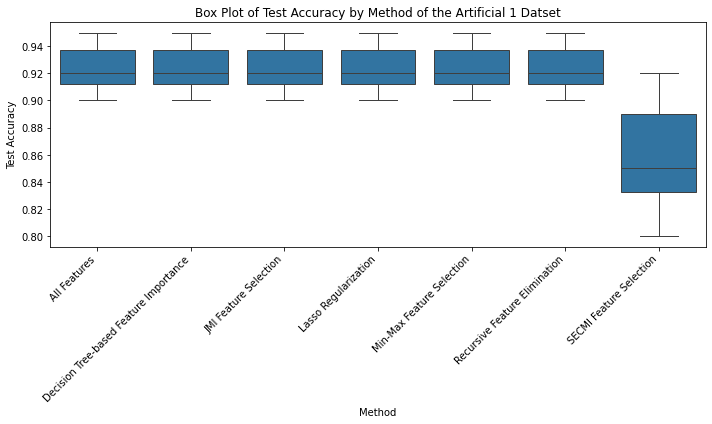


Running main_pipeline for Adult Income dataset...
Shape of Adult Income dataset: (4884, 6)
Number of categories: 2


/var/folders/r5/f91hc7617jqbmnm453nxdgr80000gn/T/ipykernel_1995/225970008.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Method': ['All Features'],


╒════════════════════════════════════════╤═════════════════════════╤═════════════════════╤═════════════════════╤══════════════════════╕
│ Method                                 │   Avg Selected Features │   Avg Test Accuracy │   Var Test Accuracy │   Avg Execution Time │
╞════════════════════════════════════════╪═════════════════════════╪═════════════════════╪═════════════════════╪══════════════════════╡
│ All Features                           │                     6   │            0.74739  │         0.000184803 │                0.028 │
├────────────────────────────────────────┼─────────────────────────┼─────────────────────┼─────────────────────┼──────────────────────┤
│ Decision Tree-based Feature Importance │                     6   │            0.74739  │         0.00014639  │                1.242 │
├────────────────────────────────────────┼─────────────────────────┼─────────────────────┼─────────────────────┼──────────────────────┤
│ JMI Feature Selection                  │      


Running main_pipeline for Iris dataset...
Shape of Iris dataset: (150, 4)
Number of categories: 3


/var/folders/r5/f91hc7617jqbmnm453nxdgr80000gn/T/ipykernel_1995/225970008.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Method': ['All Features'],


╒════════════════════════════════════════╤═════════════════════════╤═════════════════════╤═════════════════════╤══════════════════════╕
│ Method                                 │   Avg Selected Features │   Avg Test Accuracy │   Var Test Accuracy │   Avg Execution Time │
╞════════════════════════════════════════╪═════════════════════════╪═════════════════════╪═════════════════════╪══════════════════════╡
│ All Features                           │                     4   │            0.946667 │          0.00128395 │                0.003 │
├────────────────────────────────────────┼─────────────────────────┼─────────────────────┼─────────────────────┼──────────────────────┤
│ Decision Tree-based Feature Importance │                     2.9 │            0.943333 │          0.00174074 │                0.292 │
├────────────────────────────────────────┼─────────────────────────┼─────────────────────┼─────────────────────┼──────────────────────┤
│ JMI Feature Selection                  │      


Running main_pipeline for Wine dataset...
Shape of Wine dataset: (178, 13)
Number of categories: 3


/var/folders/r5/f91hc7617jqbmnm453nxdgr80000gn/T/ipykernel_1995/225970008.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Method': ['All Features'],


╒════════════════════════════════════════╤═════════════════════════╤═════════════════════╤═════════════════════╤══════════════════════╕
│ Method                                 │   Avg Selected Features │   Avg Test Accuracy │   Var Test Accuracy │   Avg Execution Time │
╞════════════════════════════════════════╪═════════════════════════╪═════════════════════╪═════════════════════╪══════════════════════╡
│ All Features                           │                    13   │            0.919444 │          0.00367798 │                0.004 │
├────────────────────────────────────────┼─────────────────────────┼─────────────────────┼─────────────────────┼──────────────────────┤
│ Decision Tree-based Feature Importance │                     4   │            0.919444 │          0.00264918 │                0.249 │
├────────────────────────────────────────┼─────────────────────────┼─────────────────────┼─────────────────────┼──────────────────────┤
│ JMI Feature Selection                  │      

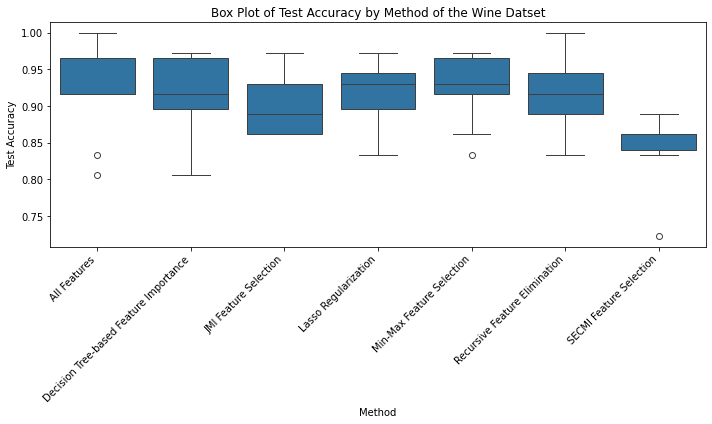


Running main_pipeline for Statlog (Heart) dataset...
Shape of Statlog (Heart) dataset: (270, 13)
Number of categories: 2


/var/folders/r5/f91hc7617jqbmnm453nxdgr80000gn/T/ipykernel_1995/225970008.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Method': ['All Features'],


╒════════════════════════════════════════╤═════════════════════════╤═════════════════════╤═════════════════════╤══════════════════════╕
│ Method                                 │   Avg Selected Features │   Avg Test Accuracy │   Var Test Accuracy │   Avg Execution Time │
╞════════════════════════════════════════╪═════════════════════════╪═════════════════════╪═════════════════════╪══════════════════════╡
│ All Features                           │                    13   │            0.731481 │          0.0033722  │                0.005 │
├────────────────────────────────────────┼─────────────────────────┼─────────────────────┼─────────────────────┼──────────────────────┤
│ Decision Tree-based Feature Importance │                     8.4 │            0.722222 │          0.00221003 │                0.336 │
├────────────────────────────────────────┼─────────────────────────┼─────────────────────┼─────────────────────┼──────────────────────┤
│ JMI Feature Selection                  │      


Running main_pipeline for Abalone dataset...
Shape of Abalone dataset: (4177, 7)
Number of categories: 2


/var/folders/r5/f91hc7617jqbmnm453nxdgr80000gn/T/ipykernel_1995/225970008.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Method': ['All Features'],


╒════════════════════════════════════════╤═════════════════════════╤═════════════════════╤═════════════════════╤══════════════════════╕
│ Method                                 │   Avg Selected Features │   Avg Test Accuracy │   Var Test Accuracy │   Avg Execution Time │
╞════════════════════════════════════════╪═════════════════════════╪═════════════════════╪═════════════════════╪══════════════════════╡
│ All Features                           │                     7   │            0.721651 │         0.000243257 │                0.051 │
├────────────────────────────────────────┼─────────────────────────┼─────────────────────┼─────────────────────┼──────────────────────┤
│ Decision Tree-based Feature Importance │                     7   │            0.721651 │         0.000326245 │                2.053 │
├────────────────────────────────────────┼─────────────────────────┼─────────────────────┼─────────────────────┼──────────────────────┤
│ JMI Feature Selection                  │      

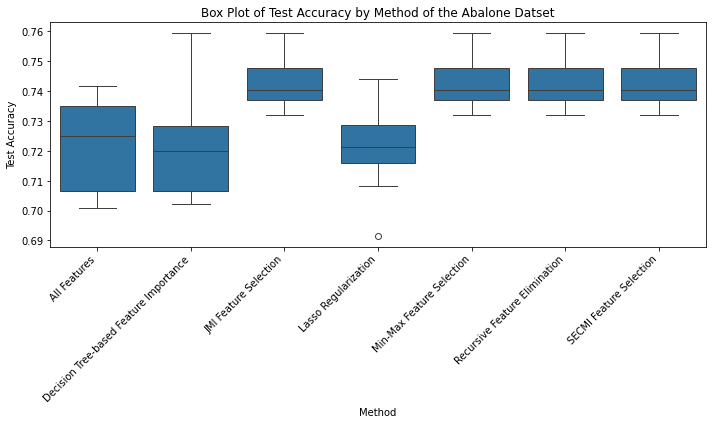

In [10]:
for name, X, y in datasets:
    print()
    print(f"Running main_pipeline for {name} dataset...")
    print(f"Shape of {name} dataset: {X.shape}")
    print(f"Number of categories: {len(set(y))}")
    results = main_pipeline(X, y, n_iterations=10, print_debug=False)
    results.sort_values(by="Method", inplace=True)
    grouped_results = aggregate_results(results)
    print(tabulate(grouped_results, headers='keys', tablefmt='fancy_grid', showindex=False))
    plot_boxplot(results, name)

# Test Artificial 2

In [11]:
X, y = X_artificial2, y_artificial2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
p = X.shape[1]
k_grid  = [int(max(np.round(percent * p),1)) for percent in [0.1, 0.3, 0.5, 0.7]]

In [12]:
# Method 0: All Features
# Fit Decision Tree Classifier
all_classifier = DecisionTreeClassifier()
all_classifier.fit(X_train, y_train)

# Evaluate on the test set
y_pred_all = all_classifier.predict(X_test)
accuracy_all = accuracy_score(y_test, y_pred_all)
print(f'Test Accuracy: {accuracy_all}')
print(f'Selected Features: {X_train.shape[1]} / {X_train.shape[1]}')

Test Accuracy: 0.78
Selected Features: 4 / 4


In [13]:
# Method 1: Lasso Regularization for Feature Selection
lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)
selected_features_lasso = SelectFromModel(lasso, prefit=True).transform(X_train)
X_test_selected_lasso = SelectFromModel(lasso, prefit=True).transform(X_test)

# Fit Decision Tree Classifier
la_classifier = DecisionTreeClassifier()
la_classifier.fit(selected_features_lasso, y_train)

# Evaluate on the test set
y_pred_lasso = la_classifier.predict(X_test_selected_lasso)
accuracy_lasso = accuracy_score(y_test, y_pred_lasso)
print(f'Test Accuracy: {accuracy_lasso}')
print(f'Selected Features: {selected_features_lasso.shape[1]}')

Test Accuracy: 0.52
Selected Features: 2


In [14]:
# Method 2: Decision Tree-based Feature Importance
param_grid_threshold = {'feature_selection__threshold': [0.01, 0.02, 0.03, 0.04, 0.05]}

dt_pipeline = Pipeline([
    ('feature_selection', SelectFromModel(DecisionTreeClassifier())),
    ('classification', DecisionTreeClassifier())
])

dt_grid_search = GridSearchCV(dt_pipeline, param_grid_threshold, cv=5)
dt_grid_search.fit(X_train, y_train)

best_model = dt_grid_search.best_estimator_

selector = best_model.named_steps['feature_selection']
selected_features_dt = selector.transform(X_train)
X_test_selected_dt = selector.transform(X_test)

dt_final_model = DecisionTreeClassifier()
dt_final_model.fit(selected_features_dt, y_train)

y_pred_dt = dt_final_model.predict(X_test_selected_dt)
accuracy_dt = accuracy_score(y_test, y_pred_dt)

print(f'Test Accuracy: {accuracy_dt}')
print(f'Selected Features: {X_test_selected_dt.shape[1]} / {X_train.shape[1]}')

Test Accuracy: 0.78
Selected Features: 4 / 4


In [15]:
# Method 3: Recursive Feature Elimination (RFE)
param_grid_k_rfe = {'n_features_to_select': k_grid}

rfe_grid_search = GridSearchCV(RFE(estimator=DecisionTreeClassifier()), param_grid_k_rfe, cv=5)
rfe_grid_search.fit(X_train, y_train)

best_n_features = rfe_grid_search.best_params_['n_features_to_select']

rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=best_n_features)

rfe.fit(X_train, y_train)

selected_features_rfe = X_train[:, rfe.support_]
X_test_selected_rfe = X_test[:, rfe.support_]

rfe_final_model = DecisionTreeClassifier()
rfe_final_model.fit(selected_features_rfe, y_train)

y_pred_rfe = rfe_final_model.predict(X_test_selected_rfe)
accuracy_rfe = accuracy_score(y_test, y_pred_rfe)
print(f'Test Accuracy: {accuracy_rfe}')
print(f'Selected Features: {X_test_selected_rfe.shape[1]} / {X_train.shape[1]}')

Test Accuracy: 0.47
Selected Features: 1 / 4


In [16]:
# Method 4: Min-Max Feature Selection
param_grid_k_min_max = {'feature_selection__num_features': k_grid}

# Define the pipeline with feature selection and classifier
min_max_pipeline = Pipeline([
    ('feature_selection', MiniMaxFeatureSelection(num_features=4)),
    ('classification', DecisionTreeClassifier())
])

# Perform grid search with cross-validation
min_max_grid_search = GridSearchCV(min_max_pipeline, param_grid_k_min_max, cv=5)
min_max_grid_search.fit(X_train, y_train)

# Get the best number of features selected
best_num_features_min_max = min_max_grid_search.best_params_['feature_selection__num_features']

# Select features using the best number of features
selected_min_max_indx = mini_max_feature_selection( X_train, y_train,
                                                     num_features=best_num_features_min_max)

selected_features_min_max = X_train[:, selected_min_max_indx]
X_test_selected_min_max = X_test[:, selected_min_max_indx]

min_max_final_model = DecisionTreeClassifier()
min_max_final_model.fit(selected_features_min_max, y_train)

y_pred_min_max = min_max_final_model.predict(X_test_selected_min_max)
accuracy_min_max = accuracy_score(y_test, y_pred_min_max)
print(f'Test Accuracy: {accuracy_min_max}')
print(f'Selected Features: {X_test_selected_min_max.shape[1]} / {X_train.shape[1]}')

Test Accuracy: 0.49
Selected Features: 1 / 4


In [17]:
# Method 5: JMI Feature Selection
param_grid_k_jmi = {'feature_selection__num_features': k_grid}

# Define the pipeline with feature selection and classifier
jmi_pipeline = Pipeline([
    ('feature_selection', JMIFeatureSelection(num_features=4)),
    ('classification', DecisionTreeClassifier())
])

# Perform grid search with cross-validation
jmi_grid_search = GridSearchCV(jmi_pipeline, param_grid_k_jmi, cv=5)
jmi_grid_search.fit(X_train, y_train)

# Get the best number of features selected
best_num_features_jmi = jmi_grid_search.best_params_['feature_selection__num_features']

# Select features using the best number of features
selected_jmi_indx = jmi_feature_selection(X_train, y_train,
                                          num_features=best_num_features_jmi)

selected_features_jmi = X_train[:, selected_jmi_indx]
X_test_selected_jmi = X_test[:, selected_jmi_indx]

jmi_final_model = DecisionTreeClassifier()
jmi_final_model.fit(selected_features_jmi, y_train)

y_pred_jmi = jmi_final_model.predict(X_test_selected_jmi)
accuracy_jmi = accuracy_score(y_test, y_pred_jmi)
print(f'Test Accuracy: {accuracy_jmi}')
print(f'Selected Features: {X_test_selected_jmi.shape[1]} / {X_train.shape[1]}')

Test Accuracy: 0.49
Selected Features: 1 / 4


In [18]:
# Method 6: SECMI Feature Selection
param_grid_k_secmi = {'feature_selection__num_features': k_grid}

# Define the pipeline with feature selection and classifier
secmi_pipeline = Pipeline([
    ('feature_selection', SECMIFeatureSelection(num_features=4)),
    ('classification', DecisionTreeClassifier())
])

# Perform grid search with cross-validation
secmi_grid_search = GridSearchCV(secmi_pipeline, param_grid_k_secmi, cv=5)
secmi_grid_search.fit(X_train, y_train)

# Get the best number of features selected
best_num_features_secmi = secmi_grid_search.best_params_['feature_selection__num_features']

# Select features using the best number of features
selected_secmi_indx = secmi_feature_selection(X_train, y_train,
                                          num_features=best_num_features_secmi)

selected_features_secmi = X_train[:, selected_secmi_indx]
X_test_selected_secmi = X_test[:, selected_secmi_indx]

secmi_final_model = DecisionTreeClassifier()
secmi_final_model.fit(selected_features_secmi, y_train)

y_pred_secmi = secmi_final_model.predict(X_test_selected_secmi)
accuracy_secmi = accuracy_score(y_test, y_pred_secmi)
print(f'Test Accuracy: {accuracy_secmi}')
print(f'Selected Features: {X_test_selected_secmi.shape[1]} / {X_train.shape[1]}')

Test Accuracy: 0.51
Selected Features: 1 / 4
